In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
stopwords_list = stopwords.words('english')

In [3]:
df = pd.read_csv('C:/Users/Dhruvil/Desktop/Data_Sets/Language_Modelling/all-the-news/articles1.csv')

In [4]:
df = df.loc[:4,:] #picking up first 4 aricles

title_list = list(df['title']) #separating title and contents of the article
article_list = list(df['content'])

train = ''
test = ''

for article in article_list[:4]:
    train = article + ' ' + train
for article in article_list[2:]:
    test = article + ' ' + test

train = train.translate(str.maketrans('','',string.punctuation)) #removing punctuation
train = train.replace('-',' ')
tokens = word_tokenize(train.lower()) #lowercasing
# tokens = [token for token in tokens if token not in stopwords.words('english')]

In [8]:
#assigning unique indices to words to feed the neural network
word2index = {}
for word in tokens:
    if word not in word2index:
        word2index[word] = len(word2index)

In [9]:
# creating a reverse dictionary to convert the output of neural networks to words

index2word = {}
for key,value in word2index.items():
    index2word[value] = key

In [10]:
INPUT_LENGTH = 20
PREDICTED_LENGTH = 1
TOTAL_LENGTH = INPUT_LENGTH + PREDICTED_LENGTH

train_tokens = []
label_tokens = []


# create input of length 20 and labels of length 20. Label for an input word is the next word
for i in range(TOTAL_LENGTH, len(tokens)-1):
    train_tokens.append(tokens[i-TOTAL_LENGTH : i-PREDICTED_LENGTH])
    label_tokens.append(tokens[i-TOTAL_LENGTH+1 : i-PREDICTED_LENGTH+1])
    
tokens_indexed = []
labels_indexed = []

#converting string tokens (words) into indices
for tokenized_sentence, tokenized_label in zip(train_tokens, label_tokens):
    tokens_indexed.append([word2index[token] for token in tokenized_sentence])
    labels_indexed.append([word2index[token] for token in tokenized_label])

# converting indices in string form to pytorch tensors
tokens_indexed = torch.LongTensor(tokens_indexed)
labels_indexed = torch.LongTensor(labels_indexed)

In [11]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 1024
LAYER_DIM = 2
SEQ_LENGTH = 30
BATCH_SIZE = 30
NUM_EPOCHS = 5
LEARNING_RATE = 0.02
NUM_BATCHES = len(train_tokens)//BATCH_SIZE

class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, batch_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.hidden2tag = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, sentence):
        embed = self.embeddings(sentence)
        lstm_out, _ =self.lstm(embed)
        lstm_out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        tag_space = self.hidden2tag(lstm_out)
        return tag_space
    

In [12]:
model = LSTM(EMBEDDING_DIM, HIDDEN_DIM, LAYER_DIM, len(word2index), BATCH_SIZE)

if torch.cuda.is_available():
    model.cuda()

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

In [14]:
with torch.no_grad():
    if torch.cuda.is_available():
        inputs = Variable(torch.tensor(tokens_indexed[:BATCH_SIZE]).cuda())
    tag_scores = model(inputs)
    print(tag_scores.shape)

C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([600, 2920])


In [17]:
loss_record = []

for j in range(10):
    
    permutation = torch.randperm(len(tokens_indexed))
    
    for i in range(0, len(tokens_indexed), BATCH_SIZE):
        optimizer.zero_grad()
        
        indices = permutation[i:i+BATCH_SIZE]
        
        batch_x, batch_y = torch.LongTensor(tokens_indexed[indices]), torch.LongTensor(labels_indexed[indices])
        
        if torch.cuda.is_available():
            batch_x = Variable(batch_x.cuda())
            batch_y = Variable(batch_y.cuda())
        
        tag_scores = model(batch_x)
        
#         print(tag_scores.shape)
        
        loss = loss_fn(tag_scores, batch_y.reshape(-1))
        
        loss_record.append(loss)
        
        loss.backward()
        
        optimizer.step()
    print("Loss at {0} epoch = {1}".format(j,loss))

Loss at 0 epoch = 4.634915351867676
Loss at 1 epoch = 4.613344669342041
Loss at 2 epoch = 4.183004379272461
Loss at 3 epoch = 3.8864636421203613
Loss at 4 epoch = 3.48156476020813
Loss at 5 epoch = 3.2878541946411133
Loss at 6 epoch = 2.7406179904937744
Loss at 7 epoch = 2.5375962257385254
Loss at 8 epoch = 2.3591787815093994
Loss at 9 epoch = 2.0523693561553955


In [63]:
softmax = nn.Softmax()
i=2058
test_sample = tokens_indexed[i]
# def generate_next_word(tokens_indexed, train_tokens, model = model):
inputs = Variable(torch.tensor(test_sample).reshape(-1,test_sample.size(0)).cuda())
scores = softmax(model(inputs))
_, index = torch.max(scores, 1)
print(index)

print("Sentence:\n", ' '.join(train_tokens[i]))
print("Prediction:\n",list(word2index.keys())[index[-1]])

C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


tensor([ 30,  39,  40,  30,  39, 760, 761, 762, 763, 663, 167, 764,  38, 765,
        178, 173, 766, 403, 126, 427], device='cuda:0')
Sentence:
 strapless with a bustier and a full skirt four musicians played “ once with feeling ” an instrumental song mr
Prediction:
 leahy


C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [493]:
generate_next_word(tokens_indexed[106], train_tokens[106])

C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dhruvil\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1])
Sentence:
 analysis police department data investigators precinct saddled twice number cases department recommends even bosses called police headquarters answer sharpest crime
Prediction:
 shells


In [ ]:
model.

In [43]:
import matplotlib.pyplot as plt

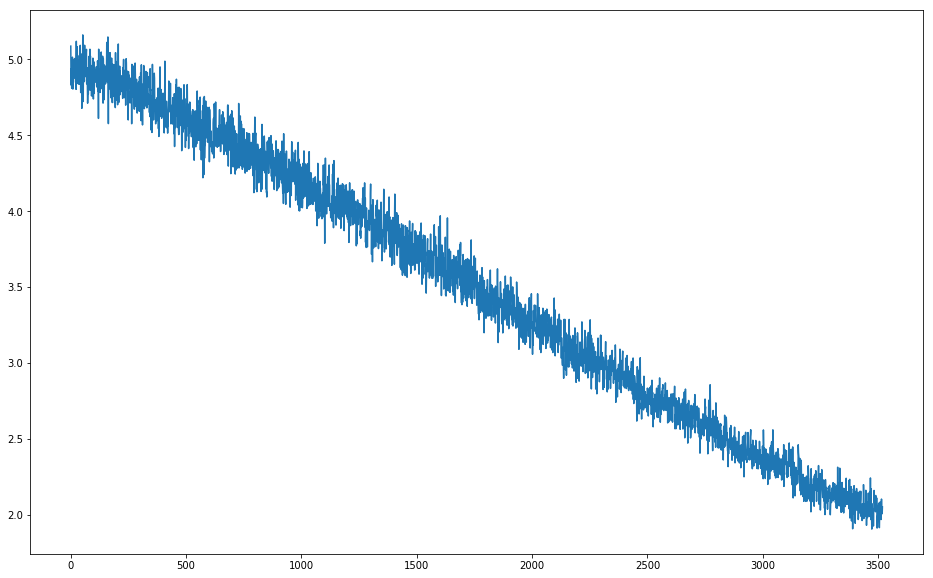

In [18]:
plt.figure(figsize = (16,10))
plt.plot(loss_record)

In [65]:
with torch.no_grad():
    with open('sample.txt', 'w') as f:
        
        # Select one word id randomly
        prob = torch.ones(len(word2index))
        input = Variable(torch.multinomial(prob, num_samples=1).unsqueeze(1).cuda())

        for i in range(1000):
            # Forward propagate RNN 
            output = model(input)

            # Sample a word id
            prob = output.exp()
            word_id = torch.multinomial(prob, num_samples=1).item()

            # Fill input with sampled word id for the next time step
            input.fill_(word_id)

            # File write
            word = index2word[word_id]
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

#             if (i+1) % 100 == 0:
#                 print('Sampled [{}/{}] words and save to {}'.format(i+1, num_samples, 'sample.txt'))

In [ ]:
input.fill_()

In [21]:
import pickle
os.chdir('C:/Users/Dhruvil/Desktop/models/')

In [22]:
pickle.dump(model, open('Language Model', 'wb'))

PermissionError: [Errno 13] Permission denied: 'Language Model'